# Notebook for analysing the noise compositions of certain cameras

Firstly, the functions to be used will be defined, and relevant modules imported...

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import tifffile as t
import scipy.optimize as sp
import numpy.ma as ma
from skimage.color import rgb2gray
from skimage.io import imread_collection
from skimage.io import concatenate_images

tifffile.py:4339: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tifffile.py:4339: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tifffile.py:4339: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


### General functions for analysing the total, read, shot and fixed pattern noise of image stacks:

In [53]:
### calculating image offset for each pixel, from 100 images, at 0 light intensity
# For CMOS cameras, each pixel has an independant offset value

def pixel_offset(image_stack_no_light):
    return np.sum(image_stack_no_light, axis=0)/ Frames_per_intensity

## repeating the offset (100) times in z axis to make future calculations easier
def repeated_offset(image_stack_no_light):
    offset = pixel_offset(image_stack_no_light)
    return np.repeat(offset[np.newaxis,:,:], Frames_per_intensity, axis=0)


### function to correct an image stack
def offset_correction(image_stack, image_stack_no_light):
    return image_stack - repeated_offset(image_stack_no_light)

In [54]:
### spatial read noise 
# read noise is independant of signal intensity, but is pixel dependant for CMOS camera 

def spatial_read_noise_sq(image_stack_no_light, num_pixels):
    return np.sum(np.diff(image_stack_no_light, axis=0)**2)/(num_pixels*2.0*(Frames_per_intensity-1))

def spatial_read_noise(image_stack_no_light, num_pixels):
    return np.sqrt(spatial_read_noise_sq(image_stack_no_light, num_pixels))


In [55]:
### Total noise of a stack

def total_noise_sq(image_stack, image_stack_no_light, num_pixels):
    offset_corrected_pixels = offset_correction(image_stack, image_stack_no_light)
    offset_corrected_pixel_mean = np.mean(offset_corrected_pixels, axis=0)
    repeated_corrected_mean = np.repeat(offset_corrected_pixel_mean[np.newaxis,:,:], Frames_per_intensity, axis=0)
    differenced_arrays = offset_corrected_pixels - repeated_corrected_mean
    return np.sum((differenced_arrays)**2)/(num_pixels*(Frames_per_intensity-1))

def total_noise(image_stack, image_stack_no_light, num_pixels):
    return np.sqrt(total_noise_sq(image_stack, image_stack_no_light, num_pixels))

In [56]:
### Differenced frame calculation, eliminating FPN to then calculate shot noise

def differenced_frame_sq(image_stack, image_stack_no_light, num_pixels):
    offset_corrected_pixels = offset_correction(image_stack, image_stack_no_light)
    return np.sum(np.diff(offset_corrected_pixels, axis=0)**2)/(num_pixels*2.0*(Frames_per_intensity-1))

In [57]:
### Shot noise 

def shot_noise_sq(image_stack, image_stack_no_light, num_pixels):
    return differenced_frame_sq(image_stack, image_stack_no_light, num_pixels) - spatial_read_noise_sq(image_stack_no_light, num_pixels)

def shot_noise(image_stack, image_stack_no_light, num_pixels):
    return np.sqrt(shot_noise_sq(image_stack, image_stack_no_light, num_pixels))

In [58]:
### Fixed pattern noise 

def fixed_pattern_noise_sq(image_stack, image_stack_no_light, num_pixels):
    return total_noise_sq(image_stack, image_stack_no_light, num_pixels) - differenced_frame_sq(image_stack, image_stack_no_light, num_pixels)

def fixed_pattern_noise(image_stack, image_stack_no_light, num_pixels):
    return np.sqrt(fixed_pattern_noise_sq(image_stack, image_stack_no_light, num_pixels))

In [59]:
### determining signal after offset correction 

def signal(image_stack, image_stack_no_light, num_pixels):
    return np.sum(offset_correction(image_stack, image_stack_no_light))/(Frames_per_intensity*num_pixels)

In [60]:
### Determining Kadc(e-/DN) - for converting DN to electrons

### change! - need to get a least squares fit of kadc for all intenities, and then use that value to calculate noises!!!

def kadc(image_stack, image_stack_no_light, num_pixels):
    return signal(image_stack, image_stack_no_light, num_pixels)/shot_noise_sq(image_stack, image_stack_no_light, num_pixels)


In [61]:
### Converting noise units into electrons for all noises...

def total_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels):
    return kadc_lsf*total_noise(image_stack, image_stack_no_light, num_pixels)

def read_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels):
    return kadc_lsf*spatial_read_noise(image_stack_no_light, num_pixels)

def shot_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels):
    return kadc_lsf*shot_noise(image_stack, image_stack_no_light, num_pixels)

def fixed_pattern_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels):
    return kadc_lsf*fixed_pattern_noise(image_stack, image_stack_no_light, num_pixels)

In [62]:
### Converting signal grey values to electrons

def signal_electrons(image_stack, image_stack_no_light, gain, num_pixels):
    return signal(image_stack, image_stack_no_light, num_pixels)/gain

In [63]:
### Converting signal electrons into photons

def signal_photons(image_stack, image_stack_no_light, gain, QE, num_pixels):
    return signal_electrons(image_stack, image_stack_no_light, gain, num_pixels)/QE

In [64]:
### Signal to noise ratios 

def SNR_electrons(image_stack, image_stack_no_light, kadc_lsf, gain, QE, num_pixels):
    return (signal_photons(image_stack, image_stack_no_light, gain, QE, num_pixels)*QE)/total_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels)

def relative_SNR_electrons(image_stack, image_stack_no_light, kadc_lsf, gain, QE, num_pixels):
    return SNR_electrons(image_stack, image_stack_no_light, kadc_lsf, gain, QE, num_pixels)/(np.sqrt(signal_photons(image_stack, image_stack_no_light, gain, QE, num_pixels)))

In [65]:
def noise_composition_graph(folder_noise_data_electrons):
    signals = np.array([])
    total_noises = np.array([])
    read_noises = np.array([])
    shot_noises = np.array([])
    FP_noises = np.array([])
    
    for n in folder_noise_data_electrons['files'].keys():
        signals = np.append(signals, folder_noise_data_electrons['files'][n]['Signal'])
        total_noises = np.append(total_noises, folder_noise_data_electrons['files'][n]['Total_noise'])
        read_noises = np.append(read_noises, folder_noise_data_electrons['files'][n]['Read_noise'])
        shot_noises = np.append(shot_noises, folder_noise_data_electrons['files'][n]['Shot_noise'])
        FP_noises = np.append(FP_noises, folder_noise_data_electrons['files'][n]['FP_noise'])
        
    #### masking for negative values
    
    signals_masked = ma.masked_where(signals <0, signals)
    ### signals_masked = ma.masked_where(signals >5900, signals)
    total_noises_masked = ma.masked_where(total_noises <0, total_noises)
    read_noises_masked = ma.masked_where(read_noises <0, read_noises)
    shot_noises_masked = ma.masked_where(shot_noises <0, shot_noises)
    FP_noises_masked = ma.masked_where(FP_noises <0, FP_noises)
    
    ### taking logs  
    
    log_signals = np.log10(signals_masked)
    log_total_noise = np.log10(total_noises_masked)
    log_read_noise = np.log10(read_noises_masked)
    log_shot_noise = np.log10(shot_noises_masked)
    log_FP_noise = np.log10(FP_noises_masked)
    
    ### masking signal log

    log_signals_masked = ma.masked_where(log_signals <0, log_signals)
    
    ### Plotting graph

    plt.scatter(log_signals_masked, log_total_noise, c='r', marker='.')
    plt.scatter(log_signals_masked, log_read_noise, marker='x')
    plt.scatter(log_signals_masked, log_shot_noise, c='g', marker='.')
    plt.scatter(log_signals_masked, log_FP_noise, marker='.')
    plt.title('Noise vs Signal')
    plt.xlabel('log10(signal) - photons')
    plt.ylabel('Noise - log10(noise) - electrons')
    plt.show()

### Functions for analysing a camera that outputs monochrome tifffile image stacks:

In [66]:
### Load an image stack

def load_image_stack(path, filename):
    """ Load an image stack """
    return t.imread(os.path.join(path, filename))

In [67]:
### To determine Kadc from a plot of signal vs shot noise sq...

def kadc_values(path, f, image_stack_no_light, num_pixels):
    
    ## read the file
    image_stack = load_image_stack(path, f)
    
    ## calculate the noises 

    Shot_noise_sq = shot_noise_sq(image_stack, image_stack_no_light, num_pixels)
    Signal_grey = signal(image_stack, image_stack_no_light, num_pixels)
        
    return {'Shot_noise_sq': Shot_noise_sq, 'Signal_grey': Signal_grey}
        
    

In [68]:
### getting kadc_values for the folder

def folder_kadc_values(path, image_stack_no_light, num_pixels):
    
    filenames = glob.glob(os.path.join(path, '*.tif'))
    
    results = {'path': path, 'files':{}}
    
    for f in filenames:
        r = kadc_values(path, f, image_stack_no_light, num_pixels)
        
        # put the calculated values into the dictionary
        results['files'][f] = r
        
    return results 

In [69]:
### obtaining lsf value for kadc
# mask the arrays for any  values 

def kadc_lsf(kadc_values):
    shot_sq = np.array([])
    signal_DN = np.array([])
    kadc_values_to_plot = kadc_values
    
    for n in kadc_values_to_plot['files'].keys():
        shot_sq = np.append(shot_sq, kadc_values_to_plot['files'][n]['Shot_noise_sq'])
        signal_DN = np.append(signal_DN, kadc_values_to_plot['files'][n]['Signal_grey'])
    
## masking - removing poor data points

    shot_sq_masked = ma.masked_where(shot_sq <0, shot_sq)
    signal_DN_masked = ma.masked_where(signal_DN <0, signal_DN)
    signal_DN_masked = ma.masked_where(signal_DN >190, signal_DN)

    plt.scatter(shot_sq_masked, signal_DN_masked)
    plt.ylabel('signal - DN')
    plt.xlabel('shot noise sq - DN')
    plt.show()

### determing gradient of line from masked arrays = kadc

    kadc_lsf, intercept = np.ma.polyfit(shot_sq_masked, signal_DN_masked, 1)
    
    print kadc_lsf
    
    return kadc_lsf


In [70]:
### Function to get nosies for any stack 

def stack_total_noise_electrons(path, f, image_stack_no_light, kadc_lsf, gain, QE, num_pixels):
    
    ## read the file
    print(f)
    image_stack = load_image_stack(path, f)
    
    ## calculate the total noises 
    Total_noise = total_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels)
    Read_noise = read_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels)
    Shot_noise = shot_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels)
    FP_noise = fixed_pattern_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels)
    Signal_grey = signal(image_stack, image_stack_no_light, num_pixels)
    Signal = signal_photons(image_stack, image_stack_no_light, gain, QE, num_pixels)
    S_N_R = SNR_electrons(image_stack, image_stack_no_light, kadc_lsf, gain, QE, num_pixels)
    rS_N_R = relative_SNR_electrons(image_stack, image_stack_no_light, kadc_lsf, gain, QE, num_pixels)
    print('Total noise:', Total_noise)
    print('Read noise:', Read_noise)
    print('Shot noise:', Shot_noise)
    print('FP_noise:', FP_noise)
    print('Signal Grey Value:', Signal_grey)
    print('Signal photons:', Signal)
    print('SNR(e-):', S_N_R)
    print('rSNR(e-):', rS_N_R)
    
    print('')
    
    # Dictionary values
    return {'Total_noise': Total_noise, 'Signal': Signal, 'SNR': S_N_R, 'rSNR': rS_N_R, 'Signal_grey': Signal_grey, 'Shot_noise': Shot_noise, 'FP_noise': FP_noise, 'Read_noise': Read_noise}


In [71]:
### all noises for folder

def folder_stack_noise_electrons(path, image_stack_no_light, kadc_lsf, gain, QE, num_pixels):
    filenames = glob.glob(os.path.join(path, '*.tif'))
    
    results = {'path': path, 'files':{}}
    
    for f in filenames:
        r = stack_total_noise_electrons(path, f, image_stack_no_light, kadc_lsf, gain, QE, num_pixels)
        
        # put the calculated values into the dictionary
        results['files'][f] = r
        
    return results 

### Functions for analysing a camera that outputs RGB images

The following functions can convert each individual image for a set power into a stack (and then convert them into grey-value if needed)

In [72]:
### converts folder containing 100 RGB images at one power into a gray-value stack

def load_convert_image_stack(path_to_folders, folder_of_images):
    filelist = glob.glob(os.path.join(path_to_folders, folder_of_images, '*.tif'))
    image_stack = imread_collection(filelist)
    image_stack1 = concatenate_images(image_stack)
    image_stack_converted_ = rgb2gray(image_stack1)
    image_stack_converted = image_stack_converted_*255
    
    return image_stack_converted

In [73]:
def load_convert_into_stack(path_to_folders, folder_of_images):
    filelist = glob.glob(os.path.join(path_to_folders, folder_of_images, '*.tif'))
    image_stack = imread_collection(filelist)
    image_stack1 = concatenate_images(image_stack)
    
    return image_stack1

In [100]:
def load_convert_stack_rgb2gray(image_stack):
    image_stack_ = rgb2gray(image_stack)
    image_stack_converted = image_stack_*255
    return image_stack_converted

In [75]:
def kadc_values2(path_to_folders, folder_of_images, image_stack_no_light, num_pixels):
    
    ### read and make stack 
    image_stack_ = load_convert_into_stack(path_to_folders, folder_of_images)
    image_stack = load_convert_stack_rgb2gray(image_stack_)
    
    ## calculate the noises 

    Shot_noise_sq = shot_noise_sq(image_stack, image_stack_no_light, num_pixels)
    Signal_grey = signal(image_stack, image_stack_no_light, num_pixels)
        
    return {'Shot_noise_sq': Shot_noise_sq, 'Signal_grey': Signal_grey}

In [76]:
def folder_kadc_values2(path, image_stack_no_light, num_pixels):
        
    folders = glob.glob(os.path.join(path, '*'))
    
    results = {'path': path, 'files':{}}
    
    for f in folders:
      
        r = kadc_values2(path, f, image_stack_no_light, num_pixels)
        
        # put the calculated values into the dictionary
        results['files'][f] = r
        
    return results 

In [77]:
### Function to get nosies for any stack 

def stack_total_noise_electrons2(path, f, image_stack_no_light, kadc_lsf, gain, QE, num_pixels):
    
    ## read the file
    print(f)
    image_stack_ = load_convert_into_stack(path, f)
    image_stack = load_convert_stack_rgb2gray(image_stack_)
    
    ## calculate the total noises 
    Total_noise = total_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels)
    Read_noise = read_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels)
    Shot_noise = shot_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels)
    FP_noise = fixed_pattern_noise_electrons(image_stack, image_stack_no_light, kadc_lsf, num_pixels)
    Signal_grey = signal(image_stack, image_stack_no_light, num_pixels)
    Signal = signal_photons(image_stack, image_stack_no_light, gain, QE, num_pixels)
    S_N_R = SNR_electrons(image_stack, image_stack_no_light, kadc_lsf, gain, QE, num_pixels)
    rS_N_R = relative_SNR_electrons(image_stack, image_stack_no_light, kadc_lsf, gain, QE, num_pixels)
    print('Total noise:', Total_noise)
    print('Read noise:', Read_noise)
    print('Shot noise:', Shot_noise)
    print('FP_noise:', FP_noise)
    print('Signal Grey Value:', Signal_grey)
    print('Signal photons:', Signal)
    print('SNR(e-):', S_N_R)
    print('rSNR(e-):', rS_N_R)
    
    print('')
    
    # Dictionary values
    return {'Total_noise': Total_noise, 'Signal': Signal, 'SNR': S_N_R, 'rSNR': rS_N_R, 'Signal_grey': Signal_grey, 'Shot_noise': Shot_noise, 'FP_noise': FP_noise, 'Read_noise': Read_noise}


In [78]:
### all noises for folder

def folder_stack_noise_electrons2(path, image_stack_no_light, kadc_lsf, gain, QE, num_pixels):
    folders = glob.glob(os.path.join(path, '*'))
    
    results = {'path': path, 'files':{}}
    
    for f in folders:
        r = stack_total_noise_electrons2(path, f, image_stack_no_light, kadc_lsf, gain, QE, num_pixels)
        
        # put the calculated values into the dictionary
        results['files'][f] = r
        
    return results 

# Now some important variables need to be defined for each camera to be tested:

Firstly, define the number of pixels each camera has (this can be directly input into the functions, but this way is easier to remember)

In [79]:
num_pixels = 1024*1280
num_pixels_FLIR = 2048*2448

Next, define how many images you took per stack i.e. how many repeats per intensity (again, this may be input directly instead)

In [80]:
Frames_per_intensity = 100.0

Now define the dark read image stack for each camera, for each condition i.e. when there is no incident light 

In [81]:
image_stack_no_light_camera2_19degrees = load_image_stack("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2", "camera2_590nm_nopower.tif")
image_stack_no_light_camera2_37degrees = load_image_stack("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2_37degrees", "camera2_37degrees_590nm_nopower.tif")
image_stack_no_light_camera1_1_19degrees = load_image_stack("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1", "camera1.1_590nm_nopower.tif")
image_stack_no_light_camera1_1_37degrees = load_image_stack("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1_37degrees/", "camera1.1_590nm_37degrees_nopower.tif")
image_stack_no_light_camera3_19degrees3 = load_convert_image_stack("D:/George/181211_camera3", "camera3_590nm_nopower")
image_stack_no_light_camera3_37degrees3 = load_convert_image_stack("D:/George/181211_camera3_37degees", "camera3_590nm_37degrees_nopower")

You can also define each camera's gain and quantum efficiency here, however in the examples, they are just input directly

# Now for the analysis:

### Camera 1 (Thorlabs DCC1545M)  - 19 degrees Celsius

In [82]:
kadc_values_to_plot_camera1_1_19degrees = folder_kadc_values("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1/", image_stack_no_light_camera1_1_19degrees, num_pixels)

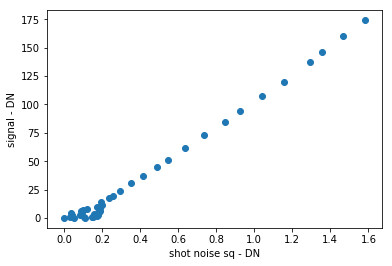

113.344999419


In [83]:
kadc_lsf_camera1_1_19degrees = kadc_lsf(kadc_values_to_plot_camera1_1_19degrees)

In [84]:
folder_noise_data_electrons_camera1_1_19degrees = folder_stack_noise_electrons("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1/", image_stack_no_light_camera1_1_19degrees, kadc_lsf_camera1_1_19degrees, 1.0, 0.55, num_pixels)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1\camera1.1_590nm_1.tif


C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


('Total noise:', 33.183287168192543)
('Read noise:', 21.132192337954717)
('Shot noise:', 25.585734271192859)
('FP_noise:', nan)
('Signal Grey Value:', 0.069699790954590876)
('Signal photons:', 0.12672689264471068)
('SNR(e-):', 0.002100448656617745)
('rSNR(e-):', 0.0059003486817046187)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1\camera1.1_590nm_10.tif
('Total noise:', 31.035064143078493)
('Read noise:', 21.132192337954717)
('Shot noise:', 22.680252646634703)
('FP_noise:', 1.4872098848192576)
('Signal Grey Value:', 2.8944589462280583)
('Signal photons:', 5.2626526295055598)
('SNR(e-):', 0.093264152214539139)
('rSNR(e-):', 0.040654852943603298)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1\camera1.1_590nm_11.tif
('Total noise:', 49.831967320304017)
('Read noise:', 21.132192337954717)
('Shot noise:', 44.829744060989682)
('FP_noise:', 5.1912870687042201)
('Signal Grey Value:', 3.2774719696045311)
('Signal photons:', 5.9590399447355109)
('SNR(e-):', 0.065770471162376248

C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


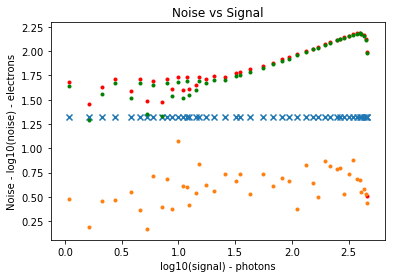

In [85]:
noise_composition_graph(folder_noise_data_electrons_camera1_1_19degrees)

### Camera 1 (Thorlabs DCC1545M)  - 37 degrees Celsius

In [86]:
kadc_values_to_plot_camera1_1_37degrees = folder_kadc_values("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1_37degrees/", image_stack_no_light_camera1_1_37degrees, num_pixels)

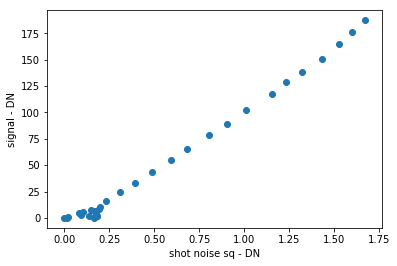

114.444279194


In [87]:
kadc_lsf_camera1_1_37degrees = kadc_lsf(kadc_values_to_plot_camera1_1_37degrees)

In [88]:
folder_noise_data_electrons_camera1_1_37degrees = folder_stack_noise_electrons("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1_37degrees/", image_stack_no_light_camera1_1_37degrees, kadc_lsf_camera1_1_37degrees, 1.0, 0.55, num_pixels)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1_37degrees\camera1.1_590nm_37degrees_1.tif
('Total noise:', 24.712141899258448)
('Read noise:', 19.491787651359289)
('Shot noise:', 15.094889019847217)
('FP_noise:', 1.7042584551347677)
('Signal Grey Value:', 0.074947982788084816)
('Signal photons:', 0.13626905961469965)
('SNR(e-):', 0.0030328404188361279)
('rSNR(e-):', 0.0082158202671893752)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1_37degrees\camera1.1_590nm_37degrees_10.tif
('Total noise:', 51.724947964050713)
('Read noise:', 19.491787651359289)
('Shot noise:', 47.754783860397161)
('FP_noise:', 3.8757030955456933)
('Signal Grey Value:', 3.6577069091795829)
('Signal photons:', 6.6503761985083321)
('SNR(e-):', 0.070714559475665795)
('rSNR(e-):', 0.027421154368151773)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1_37degrees\camera1.1_590nm_37degrees_11.tif
('Total noise:', 51.886009804674153)
('Read noise:', 19.491787651359289)
('Shot noise:', 47.81614657811206

C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


('Total noise:', 3.0267923226181712)
('Read noise:', 19.491787651359289)
('Shot noise:', nan)
('FP_noise:', nan)
('Signal Grey Value:', 253.01295951843642)
('Signal photons:', 460.02356276079342)
('SNR(e-):', 83.591119756634157)
('rSNR(e-):', 3.8973562383356963)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1_37degrees\camera1.1_590nm_37degrees_5.tif
('Total noise:', 52.558595708192449)
('Read noise:', 19.491787651359289)
('Shot noise:', 48.589275304983502)
('FP_noise:', 4.643115582027149)
('Signal Grey Value:', 1.4694664764404441)
('Signal photons:', 2.6717572298917163)
('SNR(e-):', 0.027958632772439058)
('rSNR(e-):', 0.017104777655145672)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera1.1_37degrees\camera1.1_590nm_37degrees_6.tif
('Total noise:', 52.700246843586754)
('Read noise:', 19.491787651359289)
('Shot noise:', 48.754708471391524)
('FP_noise:', 4.5127190693546746)
('Signal Grey Value:', 1.5065632781982563)
('Signal photons:', 2.7392059603604659)
('SNR(e-):', 0.0285

C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


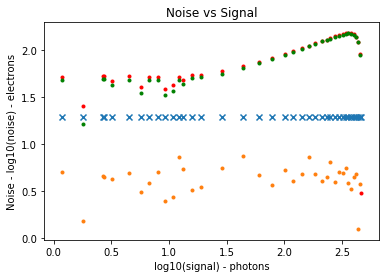

In [89]:
noise_composition_graph(folder_noise_data_electrons_camera1_1_37degrees)

### Camera 2 (Thorlabs DCC1240) - 19 degrees Celsius

In [90]:
kadc_values_to_plot_camera2 = folder_kadc_values("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2", image_stack_no_light_camera2_19degrees, num_pixels)

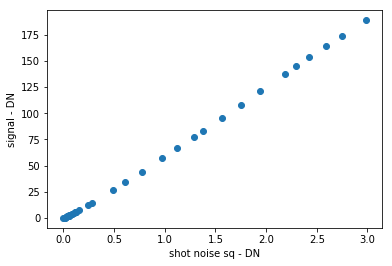

63.534302946


In [91]:
kadc_lsf_camera2_19degrees = kadc_lsf(kadc_values_to_plot_camera2)

In [92]:
folder_noise_data_electrons_camera2_19degrees = folder_stack_noise_electrons("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2", image_stack_no_light_camera2_19degrees, kadc_lsf_camera2_19degrees, 1.0, 0.58, num_pixels)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2\camera2_590nm_1.tif
('Total noise:', 37.938303815748583)
('Read noise:', 36.940717992606906)
('Shot noise:', 8.3443931791471222)
('FP_noise:', 2.251522391302081)
('Signal Grey Value:', 0.28396636199951603)
('Signal photons:', 0.48959717586123458)
('SNR(e-):', 0.0074849514458692973)
('rSNR(e-):', 0.01069718570899551)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2\camera2_590nm_10.tif
('Total noise:', 40.72373292013328)
('Read noise:', 36.940717992606906)
('Shot noise:', 16.728670773972866)
('FP_noise:', 3.7359538644181396)
('Signal Grey Value:', 3.0674962310791281)
('Signal photons:', 5.2887866053088421)
('SNR(e-):', 0.075324534641631496)
('rSNR(e-):', 0.032753554311880782)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2\camera2_590nm_11.tif
('Total noise:', 41.486865202173689)
('Read noise:', 36.940717992606906)
('Shot noise:', 18.421964999343011)
('FP_noise:', 4.1442181478536035)
('Signal Grey Value:', 3.928248390197792

C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


('Total noise:', 4.982107487285556)
('Read noise:', 36.940717992606906)
('Shot noise:', nan)
('FP_noise:', 0.075775363761271544)
('Signal Grey Value:', 253.31248134612116)
('Signal photons:', 436.74565749331236)
('SNR(e-):', 50.844443238645489)
('rSNR(e-):', 2.432927673136525)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2\camera2_590nm_5.tif
('Total noise:', 39.306845445235226)
('Read noise:', 36.940717992606906)
('Shot noise:', 12.919817207814459)
('FP_noise:', 3.672843089890768)
('Signal Grey Value:', 1.4291449127197213)
('Signal photons:', 2.4640429529650367)
('SNR(e-):', 0.036358677388926973)
('rSNR(e-):', 0.023162420384360262)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2\camera2_590nm_6.tif
('Total noise:', 39.254594281841726)
('Read noise:', 36.940717992606906)
('Shot noise:', 12.500431789944557)
('FP_noise:', 4.4772459713123496)
('Signal Grey Value:', 1.3878962936401311)
('Signal photons:', 2.3929246442071226)
('SNR(e-):', 0.035356276609949319)
('rSNR(e-):', 0.0

C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


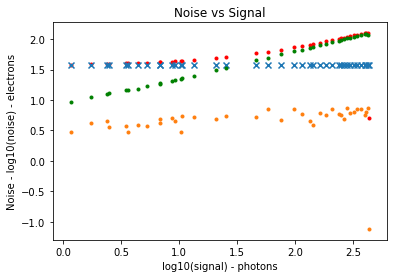

In [93]:
noise_composition_graph(folder_noise_data_electrons_camera2_19degrees)

### Camera 2 (Thorlabs DCC1240) - 37 degrees Celsius 

In [94]:
kadc_values_to_plot_camera2_37degrees = folder_kadc_values("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2_37degrees/", image_stack_no_light_camera2_37degrees, num_pixels)

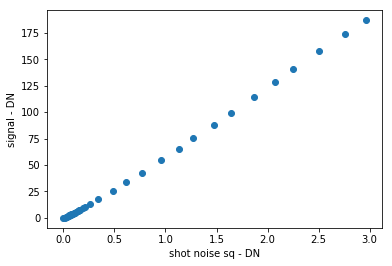

63.0899862775


In [95]:
kadc_lsf_camera2_37degrees = kadc_lsf(kadc_values_to_plot_camera2_37degrees)

In [96]:
folder_noise_data_electrons_camera2_37degrees = folder_stack_noise_electrons("C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2_37degrees/", image_stack_no_light_camera2_37degrees, kadc_lsf_camera2_37degrees, 1.0, 0.58, num_pixels)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2_37degrees\camera2_37degrees_590nm_1.tif
('Total noise:', 38.129063062062023)
('Read noise:', 37.364247158708558)
('Shot noise:', 7.3487280781121118)
('FP_noise:', 1.9325319887672188)
('Signal Grey Value:', 0.17324224090575865)
('Signal photons:', 0.29869351880303219)
('SNR(e-):', 0.0045435745594843285)
('rSNR(e-):', 0.0083135164330480436)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2_37degrees\camera2_37degrees_590nm_10.tif
('Total noise:', 41.490364938623912)
('Read noise:', 37.364247158708558)
('Shot noise:', 17.780029102391435)
('FP_noise:', 3.0387468011082999)
('Signal Grey Value:', 3.2916131515502896)
('Signal photons:', 5.6751950888798097)
('SNR(e-):', 0.079334398634948733)
('rSNR(e-):', 0.033302062874436766)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2_37degrees\camera2_37degrees_590nm_11.tif
('Total noise:', 42.337361007329235)
('Read noise:', 37.364247158708558)
('Shot noise:', 19.526647300274011)
('FP_noise

C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


('Total noise:', 3.972424955958489)
('Read noise:', 37.364247158708558)
('Shot noise:', nan)
('FP_noise:', 0.19444597340993672)
('Signal Grey Value:', 253.00075198364752)
('Signal photons:', 436.20819307525437)
('SNR(e-):', 63.689246439798907)
('rSNR(e-):', 3.0494337401316218)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2_37degrees\camera2_37degrees_590nm_5.tif
('Total noise:', 40.394327451104004)
('Read noise:', 37.364247158708558)
('Shot noise:', 14.608795240682209)
('FP_noise:', 4.7114568984311527)
('Signal Grey Value:', 2.0704642944335632)
('Signal photons:', 3.5697660248854541)
('SNR(e-):', 0.051256313078607181)
('rSNR(e-):', 0.027128606600594993)

C:/Users/Lab/Documents/G_Jupyter/Data/181114_camera2_37degrees\camera2_37degrees_590nm_6.tif
('Total noise:', 40.495701807440049)
('Read noise:', 37.364247158708558)
('Shot noise:', 15.283820796390687)
('FP_noise:', 3.196829836550299)
('Signal Grey Value:', 2.2830541915893323)
('Signal photons:', 3.9363003303264352)
('SNR(e-):',

C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


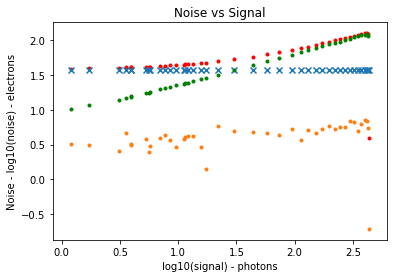

In [97]:
noise_composition_graph(folder_noise_data_electrons_camera2_37degrees)

### Camera 3 (FLIR Grasshopper Monochrome) - 19 degrees Celsius

In [101]:
kadc_values_to_plot_camera3_19degrees3 = folder_kadc_values2("D:/George/181211_camera3", image_stack_no_light_camera3_19degrees3, num_pixels_FLIR)

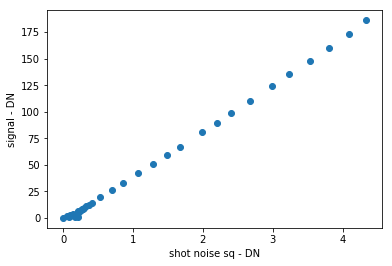

43.1564532765


In [102]:
kadc_lsf_camera3_19degrees3 = kadc_lsf(kadc_values_to_plot_camera3_19degrees3)

In [103]:
folder_noise_data_electrons_camera3_19degrees3 = folder_stack_noise_electrons2("D:/George/181211_camera3", image_stack_no_light_camera3_19degrees3, kadc_lsf_camera3_19degrees3, 1.0, 0.69, num_pixels_FLIR)

D:/George/181211_camera3\camera3_590nm_10
('Total noise:', 19.98749239015681)
('Read noise:', 6.5638709469673016)
('Shot noise:', 18.840667152966446)
('FP_noise:', 1.2019615090618141)
('Signal Grey Value:', 2.6774091154609554)
('Signal photons:', 3.8803030658854429)
('SNR(e-):', 0.13395422813416516)
('rSNR(e-):', 0.068002300149770725)

D:/George/181211_camera3\camera3_590nm_11
('Total noise:', 15.148980893413729)
('Read noise:', 6.5638709469673016)
('Shot noise:', 13.600749558142038)
('FP_noise:', 1.1945006309215445)
('Signal Grey Value:', 3.0743093692555949)
('Signal photons:', 4.4555208250081089)
('SNR(e-):', 0.20293836205128504)
('rSNR(e-):', 0.09614238951480357)

D:/George/181211_camera3\camera3_590nm_12
('Total noise:', 20.52824447300096)
('Read noise:', 6.5638709469673016)
('Shot noise:', 19.416820250135103)
('FP_noise:', 1.1452120802700385)
('Signal Grey Value:', 3.401667213190755)
('Signal photons:', 4.9299524828851524)
('SNR(e-):', 0.16570667879879725)
('rSNR(e-):', 0.07463089

C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


('Total noise:', 6.2086919988876161)
('Read noise:', 6.5638709469673016)
('Shot noise:', nan)
('FP_noise:', 1.1789234090715155)
('Signal Grey Value:', 1.0130229256822609)
('Signal photons:', 1.4681491676554508)
('SNR(e-):', 0.16316205182408142)
('rSNR(e-):', 0.13465859117420612)

D:/George/181211_camera3\camera3_590nm_40
('Total noise:', 87.481240708158651)
('Read noise:', 6.5638709469673016)
('Shot noise:', 87.221899441245043)
('FP_noise:', 1.4910841330017988)
('Signal Grey Value:', 173.55049040550864)
('Signal photons:', 251.52244986305601)
('SNR(e-):', 1.9838594994837908)
('rSNR(e-):', 0.12508998318860384)

D:/George/181211_camera3\camera3_590nm_41
('Total noise:', 90.156897930682774)
('Read noise:', 6.5638709469673016)
('Shot noise:', 89.896719057450824)
('FP_noise:', 1.9395219464780142)
('Signal Grey Value:', 186.16724987553076)
('Signal photons:', 269.80760851526196)
('SNR(e-):', 2.0649251931745214)
('rSNR(e-):', 0.12571214208784484)

D:/George/181211_camera3\camera3_590nm_42
('T

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


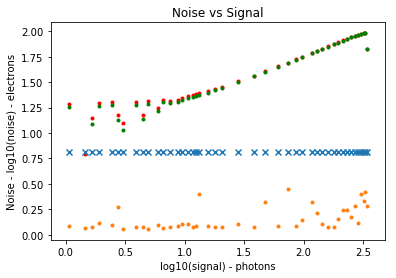

In [104]:
noise_composition_graph(folder_noise_data_electrons_camera3_19degrees3)

### Camera 3 (FLIR Grasshopper Monochrome) - 37 degrees Celsius

In [105]:
kadc_values_to_plot_camera3_37degrees3 = folder_kadc_values2("D:/George/181211_camera3_37degees", image_stack_no_light_camera3_37degrees3, num_pixels_FLIR)

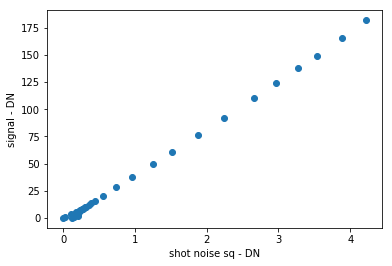

43.254765337


In [106]:
kadc_lsf_camera3_37degrees3 = kadc_lsf(kadc_values_to_plot_camera3_37degrees3)

In [107]:
folder_noise_data_electrons_camera3_37degrees3 = folder_stack_noise_electrons2("D:/George/181211_camera3_37degees", image_stack_no_light_camera3_37degrees3, kadc_lsf_camera3_37degrees3, 1.0, 0.69, num_pixels_FLIR)

D:/George/181211_camera3_37degees\camera3_590nm_37degrees_1


C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


('Total noise:', 2.5207665441399962)
('Read noise:', 7.4262631886767547)
('Shot noise:', nan)
('FP_noise:', 1.2328373107244746)
('Signal Grey Value:', 0.028398984023946229)
('Signal photons:', 0.04115794786079164)
('SNR(e-):', 0.011266011162344684)
('rSNR(e-):', 0.055532000751521857)

D:/George/181211_camera3_37degees\camera3_590nm_37degrees_10
('Total noise:', 19.749403957362926)
('Read noise:', 7.4262631886767547)
('Shot noise:', 18.25701619605897)
('FP_noise:', 1.2533679988125721)
('Signal Grey Value:', 5.1193100733537698)
('Signal photons:', 7.4192899613822751)
('SNR(e-):', 0.25921339623240636)
('rSNR(e-):', 0.095164784828947857)

D:/George/181211_camera3_37degees\camera3_590nm_37degrees_11
('Total noise:', 21.450726846219613)
('Read noise:', 7.4262631886767547)
('Shot noise:', 20.016041143262324)
('FP_noise:', 2.0838412211253683)
('Signal Grey Value:', 5.7062692440256457)
('Signal photons:', 8.2699554261241257)
('SNR(e-):', 0.26601752401836659)
('rSNR(e-):', 0.092503605929795618)


C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


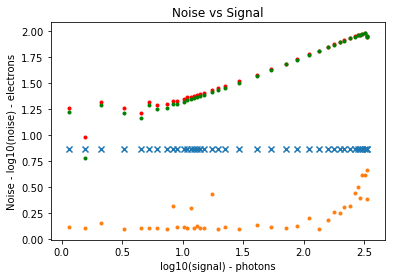

In [108]:
noise_composition_graph(folder_noise_data_electrons_camera3_37degrees3)

### Finally, the rSNR graph to compare cameras/conditions

This part is super messy becuase of the masking etc. maybe there's a better way?

C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log10
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in log10
C:\Users\Lab\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encou

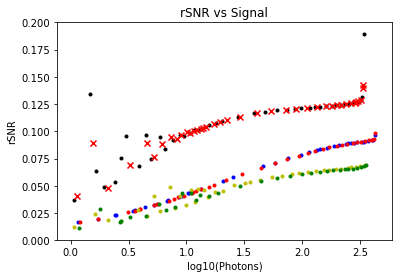

In [109]:
### rSNR graph for camera 2 at room temp and 37 degrees 

signal_camera2_19degrees = np.array([])
signal_camera2_37degrees = np.array([])
signal_camera1_1_19degrees = np.array([])
signal_camera1_1_37degrees = np.array([])
signal_camera3_19degrees = np.array([])
signal_camera3_37degrees = np.array([])

rSNR_electrons_19degrees = np.array([])
rSNR_electrons_37degrees = np.array([])
rSNR_electrons_camera1_1_19degrees = np.array([])
rSNR_electrons_camera1_1_37degrees = np.array([])
rSNR_electrons_camera3_19degrees = np.array([])
rSNR_electrons_camera3_37degrees = np.array([])

### 19 degrees camera 2

for n in folder_noise_data_electrons_camera2_19degrees['files'].keys():
    signal_camera2_19degrees = np.append(signal_camera2_19degrees, folder_noise_data_electrons_camera2_19degrees['files'][n]['Signal'])
    rSNR_electrons_19degrees = np.append(rSNR_electrons_19degrees, folder_noise_data_electrons_camera2_19degrees['files'][n]['rSNR'])

### 37 degrees camera 2

for n in folder_noise_data_electrons_camera2_37degrees['files'].keys():
    signal_camera2_37degrees = np.append(signal_camera2_37degrees, folder_noise_data_electrons_camera2_37degrees['files'][n]['Signal'])
    rSNR_electrons_37degrees = np.append(rSNR_electrons_37degrees, folder_noise_data_electrons_camera2_37degrees['files'][n]['rSNR'])

### 19 degrees camera 1.1

for n in folder_noise_data_electrons_camera1_1_19degrees['files'].keys():
    signal_camera1_1_19degrees = np.append(signal_camera1_1_19degrees, folder_noise_data_electrons_camera1_1_19degrees['files'][n]['Signal'])
    rSNR_electrons_camera1_1_19degrees = np.append(rSNR_electrons_camera1_1_19degrees, folder_noise_data_electrons_camera1_1_19degrees['files'][n]['rSNR'])

### 37 degrees camera 1.1

for n in folder_noise_data_electrons_camera1_1_37degrees['files'].keys():
    signal_camera1_1_37degrees = np.append(signal_camera1_1_37degrees, folder_noise_data_electrons_camera1_1_37degrees['files'][n]['Signal'])
    rSNR_electrons_camera1_1_37degrees = np.append(rSNR_electrons_camera1_1_37degrees, folder_noise_data_electrons_camera1_1_37degrees['files'][n]['rSNR'])

### 19 degrees camera 3 11/12/18

for n in folder_noise_data_electrons_camera3_19degrees3['files'].keys():
    signal_camera3_19degrees = np.append(signal_camera3_19degrees, folder_noise_data_electrons_camera3_19degrees3['files'][n]['Signal'])
    rSNR_electrons_camera3_19degrees = np.append(rSNR_electrons_camera3_19degrees, folder_noise_data_electrons_camera3_19degrees3['files'][n]['rSNR'])

### 37 degrees camera 3 - 11/12/18

for n in folder_noise_data_electrons_camera3_37degrees3['files'].keys():
    signal_camera3_37degrees = np.append(signal_camera3_37degrees, folder_noise_data_electrons_camera3_37degrees3['files'][n]['Signal'])
    rSNR_electrons_camera3_37degrees = np.append(rSNR_electrons_camera3_37degrees, folder_noise_data_electrons_camera3_37degrees3['files'][n]['rSNR'])
    
### masking camera 2

signal_camera2_19degrees_masked = ma.masked_where(signal_camera2_19degrees <0, signal_camera2_19degrees)
signal_camera2_37degrees_masked = ma.masked_where(signal_camera2_37degrees <0, signal_camera2_37degrees)

rSNR_electrons_19degrees_masked = ma.masked_where(rSNR_electrons_19degrees >1, rSNR_electrons_19degrees)
rSNR_electrons_37degrees_masked = ma.masked_where(rSNR_electrons_37degrees >1, rSNR_electrons_37degrees)

### masking camera 1.1

signal_camera1_1_19degrees_masked = ma.masked_where(signal_camera1_1_19degrees <0, signal_camera1_1_19degrees)
signal_camera1_1_37degrees_masked = ma.masked_where(signal_camera1_1_37degrees <0, signal_camera1_1_37degrees)

rSNR_electrons_camera1_1_19degrees_masked = ma.masked_where(rSNR_electrons_camera1_1_19degrees >0.07, rSNR_electrons_camera1_1_19degrees)
rSNR_electrons_camera1_1_37degrees_masked = ma.masked_where(rSNR_electrons_camera1_1_37degrees >0.07, rSNR_electrons_camera1_1_37degrees)

### masking camera 3

signal_camera3_19degrees_masked = ma.masked_where(signal_camera3_19degrees <0, signal_camera3_19degrees)
signal_camera3_37degrees_masked = ma.masked_where(signal_camera3_37degrees <0, signal_camera3_37degrees)


rSNR_electrons_camera3_19degrees_masked = ma.masked_where(rSNR_electrons_camera3_19degrees >1, rSNR_electrons_camera3_19degrees)
rSNR_electrons_camera3_37degrees_masked = ma.masked_where(rSNR_electrons_camera3_37degrees >1, rSNR_electrons_camera3_37degrees)


### taking logs of signals and masking camera 2

log_signal_camera2_19degrees = np.log10(signal_camera2_19degrees_masked)
log_signal_camera2_37degrees = np.log10(signal_camera2_37degrees_masked)

log_signal_camera2_19degrees_masked = ma.masked_where(log_signal_camera2_19degrees <0, log_signal_camera2_19degrees)
log_signal_camera2_37degrees_masked = ma.masked_where(log_signal_camera2_37degrees <0, log_signal_camera2_37degrees)

### taking logs and masking camera 1.1

log_signal_camera1_1_19degrees = np.log10(signal_camera1_1_19degrees_masked)
log_signal_camera1_1_37degrees = np.log10(signal_camera1_1_37degrees_masked)

log_signal_camera1_1_19degrees_masked = ma.masked_where(log_signal_camera1_1_19degrees <0, log_signal_camera1_1_19degrees)
log_signal_camera1_1_37degrees_masked = ma.masked_where(log_signal_camera1_1_37degrees <0, log_signal_camera1_1_37degrees)

### logs and masking camera 3

log_signal_camera3_19degrees = np.log10(signal_camera3_19degrees_masked)
log_signal_camera3_37degrees = np.log10(signal_camera3_37degrees_masked)

log_signal_camera3_19degrees_masked = ma.masked_where(log_signal_camera3_19degrees <0, log_signal_camera3_19degrees)
log_signal_camera3_37degrees_masked = ma.masked_where(log_signal_camera3_37degrees <0, log_signal_camera3_37degrees)


### Plotting graph

plt.scatter(log_signal_camera2_19degrees_masked, rSNR_electrons_19degrees_masked, c='b', marker='.')
plt.scatter(log_signal_camera2_37degrees_masked, rSNR_electrons_37degrees_masked, c='r', marker='.')
plt.scatter(log_signal_camera1_1_19degrees_masked, rSNR_electrons_camera1_1_19degrees_masked, c='y', marker='.')
plt.scatter(log_signal_camera1_1_37degrees_masked, rSNR_electrons_camera1_1_37degrees_masked, c='g', marker='.')
plt.scatter(log_signal_camera3_19degrees_masked, rSNR_electrons_camera3_19degrees_masked, c='k', marker='.')
plt.scatter(log_signal_camera3_37degrees_masked, rSNR_electrons_camera3_37degrees_masked, c='r', marker='x')
plt.title('rSNR vs Signal')
plt.ylabel('rSNR')
plt.xlabel('log10(Photons)')
plt.ylim(top=0.2)
plt.show()


